# پیتر و گرگ: مقدمه‌ای بر یادگیری تقویتی

در این آموزش، یاد می‌گیریم که چگونه یادگیری تقویتی را برای مسئله‌ی یافتن مسیر به کار ببریم. این موضوع از داستان موسیقیایی [پیتر و گرگ](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) اثر آهنگساز روسی [سرگئی پروکفیف](https://en.wikipedia.org/wiki/Sergei_Prokofiev) الهام گرفته شده است. این داستان درباره‌ی پیشگام جوانی به نام پیتر است که شجاعانه از خانه‌اش بیرون می‌رود و به جنگل می‌رود تا گرگ را دنبال کند. ما الگوریتم‌های یادگیری ماشین را آموزش خواهیم داد که به پیتر کمک می‌کنند تا منطقه‌ی اطراف را کشف کند و یک نقشه‌ی ناوبری بهینه بسازد.

ابتدا، بیایید تعدادی کتابخانه‌ی مفید را وارد کنیم:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## مروری بر یادگیری تقویتی

**یادگیری تقویتی** (RL) یک تکنیک یادگیری است که به ما امکان می‌دهد رفتار بهینه یک **عامل** را در یک **محیط** با انجام آزمایش‌های متعدد یاد بگیریم. عامل در این محیط باید یک **هدف** داشته باشد که توسط یک **تابع پاداش** تعریف می‌شود.

## محیط

برای ساده‌تر کردن موضوع، بیایید دنیای پیتر را به یک صفحه مربعی با اندازه `width` x `height` در نظر بگیریم. هر سلول در این صفحه می‌تواند یکی از موارد زیر باشد:
* **زمین**، که پیتر و موجودات دیگر می‌توانند روی آن راه بروند
* **آب**، که به وضوح نمی‌توانید روی آن راه بروید
* **درخت** یا **چمن** - مکانی که می‌توانید کمی استراحت کنید
* **سیب**، که چیزی است که پیتر خوشحال می‌شود پیدا کند تا خودش را تغذیه کند
* **گرگ**، که خطرناک است و باید از آن اجتناب کرد

برای کار با محیط، ما یک کلاس به نام `Board` تعریف خواهیم کرد. برای جلوگیری از شلوغ شدن بیش از حد این دفترچه، تمام کدهای مربوط به کار با صفحه را به یک ماژول جداگانه به نام `rlboard` منتقل کرده‌ایم که اکنون آن را وارد می‌کنیم. شما می‌توانید داخل این ماژول را بررسی کنید تا جزئیات بیشتری درباره پیاده‌سازی داخلی آن به دست آورید.


In [2]:
from rlboard import *

حالا بیایید یک صفحه تصادفی ایجاد کنیم و ببینیم چگونه به نظر می‌رسد:


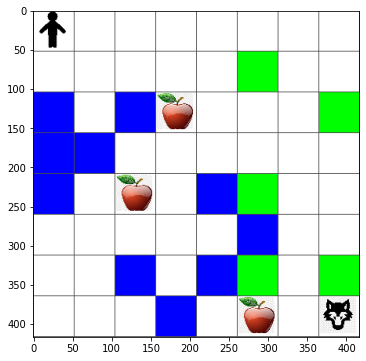

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## اقدامات و سیاست‌ها

در مثال ما، هدف پیتر پیدا کردن یک سیب است، در حالی که باید از گرگ و سایر موانع دوری کند. برای این کار، او می‌تواند اساساً در اطراف قدم بزند تا سیب را پیدا کند. بنابراین، در هر موقعیتی می‌تواند یکی از اقدامات زیر را انتخاب کند: بالا، پایین، چپ و راست. ما این اقدامات را به صورت یک دیکشنری تعریف می‌کنیم و آنها را به زوج‌های تغییرات مختصات مربوطه نگاشت می‌کنیم. برای مثال، حرکت به راست (`R`) به زوج `(1,0)` مربوط می‌شود.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

استراتژی عامل ما (پیتر) با چیزی که به آن **سیاست** گفته می‌شود تعریف شده است. بیایید ساده‌ترین سیاست که **حرکت تصادفی** نام دارد را بررسی کنیم.

## حرکت تصادفی

ابتدا بیایید مسئله خود را با پیاده‌سازی یک استراتژی حرکت تصادفی حل کنیم.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

بیایید آزمایش قدم‌زنی تصادفی را چندین بار اجرا کنیم و میانگین تعداد قدم‌های برداشته‌شده را ببینیم:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## تابع پاداش

برای هوشمندتر کردن سیاست خود، باید بفهمیم کدام حرکات "بهتر" از دیگران هستند.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## یادگیری Q

ساخت یک جدول Q یا آرایه چند‌بعدی. از آنجا که صفحه ما ابعاد `width` x `height` دارد، می‌توانیم جدول Q را با یک آرایه numpy با شکل `width` x `height` x `len(actions)` نمایش دهیم:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

جدول Q را به تابع رسم منتقل کنید تا جدول را روی تخته نمایش دهید:


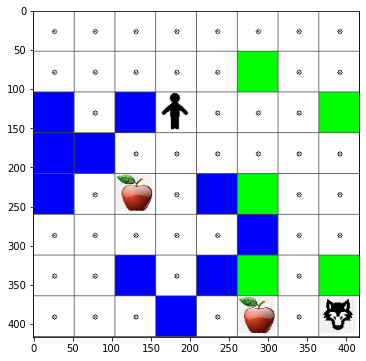

In [9]:
m.plot(Q)

## ماهیت Q-Learning: معادله بلمن و الگوریتم یادگیری

کد شبه‌ای برای الگوریتم یادگیری ما بنویسید:

* مقداردهی اولیه جدول Q با اعداد برابر برای تمام حالت‌ها و اقدامات
* تنظیم نرخ یادگیری $\alpha\leftarrow 1$
* شبیه‌سازی را بارها تکرار کنید
   1. از یک موقعیت تصادفی شروع کنید
   1. تکرار کنید
        1. یک اقدام $a$ را در حالت $s$ انتخاب کنید
        2. اقدام را اجرا کنید و به حالت جدید $s'$ بروید
        3. اگر به شرایط پایان بازی برسیم یا مجموع پاداش خیلی کم باشد - شبیه‌سازی را متوقف کنید  
        4. پاداش $r$ را در حالت جدید محاسبه کنید
        5. تابع Q را طبق معادله بلمن به‌روزرسانی کنید: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. مجموع پاداش را به‌روزرسانی کنید و $\alpha$ را کاهش دهید.

## بهره‌برداری در مقابل اکتشاف

بهترین رویکرد، ایجاد تعادل بین اکتشاف و بهره‌برداری است. هرچه بیشتر درباره محیط خود یاد بگیریم، احتمال بیشتری وجود دارد که مسیر بهینه را دنبال کنیم، اما گاهی انتخاب مسیر ناشناخته نیز مفید است.

## پیاده‌سازی در پایتون

اکنون آماده‌ایم تا الگوریتم یادگیری را پیاده‌سازی کنیم. پیش از آن، به تابعی نیاز داریم که اعداد دلخواه در جدول Q را به یک بردار احتمالات برای اقدامات مربوطه تبدیل کند:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

ما مقدار کمی `eps` به بردار اصلی اضافه می‌کنیم تا در حالت اولیه، زمانی که تمام مؤلفه‌های بردار یکسان هستند، از تقسیم بر صفر جلوگیری کنیم.

الگوریتم یادگیری واقعی که اجرا خواهیم کرد برای 5000 آزمایش، که به آن **دوره‌ها** نیز گفته می‌شود:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

پس از اجرای این الگوریتم، جدول Q باید با مقادیر به‌روزرسانی شود که جذابیت اقدامات مختلف را در هر مرحله تعریف می‌کند. جدول را اینجا مشاهده کنید:


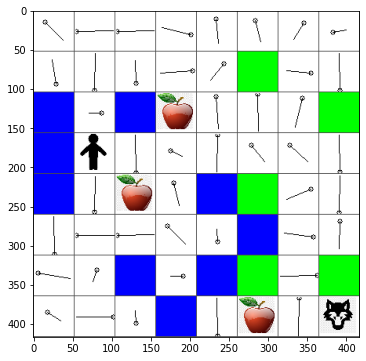

In [12]:
m.plot(Q)

## بررسی سیاست

از آنجا که جدول Q "جذابیت" هر اقدام را در هر حالت فهرست می‌کند، استفاده از آن برای تعریف مسیر کارآمد در دنیای ما بسیار آسان است. در ساده‌ترین حالت، می‌توانیم فقط اقدامی را انتخاب کنیم که با بالاترین مقدار جدول Q مطابقت دارد:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

اگر کد بالا را چندین بار امتحان کنید، ممکن است متوجه شوید که گاهی اوقات فقط "متوقف" می‌شود و شما باید دکمه توقف را در نوت‌بوک فشار دهید تا آن را قطع کنید.

> **وظیفه ۱:** تابع `walk` را تغییر دهید تا طول مسیر را به تعداد مشخصی از مراحل (مثلاً ۱۰۰) محدود کند و مشاهده کنید که کد بالا گاهی این مقدار را بازمی‌گرداند.

> **وظیفه ۲:** تابع `walk` را تغییر دهید تا به مکان‌هایی که قبلاً در آن‌ها بوده است، بازنگردد. این کار از حلقه زدن `walk` جلوگیری می‌کند، اما همچنان ممکن است عامل در مکانی "گیر بیفتد" که قادر به فرار از آن نباشد.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


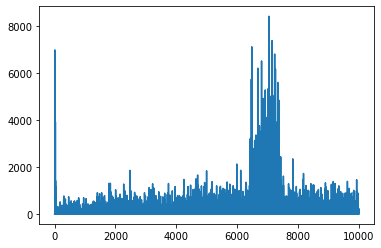

In [15]:
plt.plot(lpath)

آنچه در اینجا مشاهده می‌کنیم این است که در ابتدا طول متوسط مسیر افزایش یافته است. احتمالاً این به این دلیل است که وقتی هیچ اطلاعاتی درباره محیط نداریم - احتمال دارد در وضعیت‌های نامطلوب، مانند افتادن در آب یا مواجهه با گرگ، گرفتار شویم. با یادگیری بیشتر و استفاده از این دانش، می‌توانیم مدت بیشتری محیط را کاوش کنیم، اما هنوز به‌خوبی نمی‌دانیم سیب‌ها کجا هستند.

وقتی به اندازه کافی یاد بگیریم، دستیابی به هدف برای عامل آسان‌تر می‌شود و طول مسیر شروع به کاهش می‌کند. با این حال، هنوز در حالت کاوش هستیم، بنابراین اغلب از مسیر بهینه منحرف می‌شویم و گزینه‌های جدیدی را بررسی می‌کنیم که باعث طولانی‌تر شدن مسیر نسبت به حالت بهینه می‌شود.

آنچه همچنین در این نمودار مشاهده می‌کنیم این است که در یک نقطه طول مسیر به‌طور ناگهانی افزایش یافته است. این نشان‌دهنده ماهیت تصادفی فرآیند است و اینکه ممکن است در یک نقطه "ضریب‌های جدول Q" را خراب کنیم، با جایگزین کردن آنها با مقادیر جدید. این موضوع باید به‌طور ایده‌آل با کاهش نرخ یادگیری به حداقل برسد (یعنی در انتهای آموزش، مقادیر جدول Q را فقط با مقدار کمی تنظیم کنیم).

به‌طور کلی، مهم است به یاد داشته باشیم که موفقیت و کیفیت فرآیند یادگیری به‌شدت به پارامترهایی مانند نرخ یادگیری، کاهش نرخ یادگیری و عامل تخفیف بستگی دارد. این پارامترها اغلب **فراپارامتر** نامیده می‌شوند تا آنها را از **پارامترها** که در طول آموزش بهینه‌سازی می‌شوند (مانند ضریب‌های جدول Q) متمایز کنیم. فرآیند یافتن بهترین مقادیر فراپارامترها **بهینه‌سازی فراپارامتر** نامیده می‌شود و شایسته یک موضوع جداگانه است.


## تمرین
#### دنیای واقعی‌تر برای داستان پیتر و گرگ

در وضعیت ما، پیتر تقریباً بدون خستگی یا گرسنگی می‌توانست حرکت کند. در یک دنیای واقعی‌تر، او باید هر از گاهی بنشیند و استراحت کند و همچنین خودش را تغذیه کند. بیایید دنیای خود را واقعی‌تر کنیم با اجرای قوانین زیر:

1. با حرکت از یک مکان به مکان دیگر، پیتر **انرژی** از دست می‌دهد و مقداری **خستگی** کسب می‌کند.
2. پیتر می‌تواند با خوردن سیب انرژی بیشتری به دست آورد.
3. پیتر می‌تواند با استراحت زیر درخت یا روی چمن (یعنی رفتن به مکانی در صفحه که درخت یا چمن - زمین سبز - دارد) از شر خستگی خلاص شود.
4. پیتر باید گرگ را پیدا کرده و بکشد.
5. برای کشتن گرگ، پیتر باید سطح مشخصی از انرژی و خستگی داشته باشد، در غیر این صورت در نبرد شکست می‌خورد.

تابع پاداش بالا را مطابق قوانین بازی تغییر دهید، الگوریتم یادگیری تقویتی را اجرا کنید تا بهترین استراتژی برای برنده شدن در بازی را یاد بگیرید، و نتایج حرکت تصادفی را با الگوریتم خود از نظر تعداد بازی‌های برده و باخته مقایسه کنید.

> **Note**: ممکن است نیاز باشد که هایپرپارامترها را تنظیم کنید تا کار کند، به خصوص تعداد دوره‌ها. از آنجا که موفقیت در بازی (مبارزه با گرگ) یک رویداد نادر است، می‌توانید انتظار زمان آموزش طولانی‌تری داشته باشید.



---

**سلب مسئولیت**:  
این سند با استفاده از سرویس ترجمه هوش مصنوعی [Co-op Translator](https://github.com/Azure/co-op-translator) ترجمه شده است. در حالی که ما تلاش می‌کنیم دقت را حفظ کنیم، لطفاً توجه داشته باشید که ترجمه‌های خودکار ممکن است شامل خطاها یا نادرستی‌ها باشند. سند اصلی به زبان اصلی آن باید به عنوان منبع معتبر در نظر گرفته شود. برای اطلاعات حساس، توصیه می‌شود از ترجمه حرفه‌ای انسانی استفاده کنید. ما مسئولیتی در قبال سوء تفاهم‌ها یا تفسیرهای نادرست ناشی از استفاده از این ترجمه نداریم.
